In [1]:
%matplotlib inline

from itertools import combinations
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from scipy.stats import spearmanr

pd.set_option("display.max_columns", 101)
pd.set_option("display.float_format", lambda x: "%.2f" % x )


# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src', 'data')
sys.path.append(src_dir)

# import my method from the source code
%aimport utils

/Users/bull/anaconda/envs/farmdrive/lib/python3.5/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
targets = pd.read_csv("../data/processed/targets-by-county.csv", index_col=0)

In [3]:
pct_to_float = lambda x: float(x[:-1]) if isinstance(x, str) and x[-1] == '%' else x

## Percent of Households Involved in Crop Farming

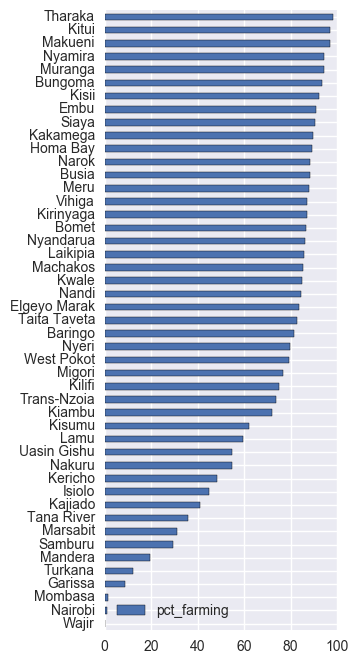

In [4]:
se_data = '../data/raw/Socio Econonomic Data/'
fp = os.path.join(se_data,
                  'KIHBS2005',
                  'Proportion_of_Households_Engaged_in_Crop_Farming_by_Region_County_Estimates_-_2005_6.csv')

pct_households_farming = pd.read_csv(fp,
                                     index_col=0)

pct_households_farming.drop('Kenya average', inplace=True)

pct_households_farming.index = utils.resolve_county_names(pct_households_farming.index, targets.index)

pct_households_farming['pct_farming'] = pct_households_farming['Percent of households'].apply(pct_to_float)

pct_households_farming = pct_households_farming[['pct_farming']]

(pct_households_farming[['pct_farming']]
 .sort_values(by='pct_farming')
 .plot
 .barh(figsize=(3, 8)))

## Household Characteristics

 - Age
 - Gender
 - Marital Status
 - Population   

In [5]:
se_data = '../data/raw/Socio Econonomic Data/'
fp = os.path.join(se_data,
                  'KIHBS2005',
                  'Population_and_Household_Characteristics_County_estimates_2005_6.csv')

household_characteristics = pd.read_csv(fp,
                                     index_col=0)

household_characteristics.index = utils.resolve_county_names(household_characteristics.index, targets.index)

household_characteristics = household_characteristics.applymap(pct_to_float)

household_characteristics.describe()

,Age 0 - 14,Age 15 - 64,Age 65 +,% Male,% Female,% household size: 1 -2,% household size: 3-4,% household size: 5 - 6,% household size: 7+,% Male Head of Household,% Female Head of Household,Monogamous-Marital status of head,Polygamous-Marital status of head,Living Together-Marital status of head,Seperated-Marital status of head,Divorced-Marital status of head,Widow or Widower-Marital status of head,Never Married-Marital status of head,Monogamous-% of population 10 years+,Polygamous % of population 10 years+,Living Together % of population 10 years+,Separated % of population 10 years+,Divorced % of population 10 years+,Widow/Widower % of population 10 years+,Never Married % of population 10 years+,Total Population
count,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00
mean,43.40,52.62,3.68,49.42,50.58,16.22,25.24,28.06,30.49,69.76,30.24,62.44,12.11,0.74,2.49,2.09,15.25,4.88,42.56,7.25,0.57,1.89,1.19,6.62,38.19,755641.43
std,5.54,5.36,1.49,2.16,2.16,7.17,6.02,4.34,10.95,10.86,10.86,10.04,8.51,2.69,1.61,2.58,6.02,3.99,6.65,5.82,2.02,1.08,1.42,2.56,4.51,495896.49
min,33.10,41.30,1.10,44.20,43.80,1.80,17.10,15.50,10.20,20.90,13.50,37.70,1.00,0.00,0.00,0.00,6.10,0.40,29.40,0.50,0.00,0.00,0.00,2.70,27.60,80472.00
25%,39.50,49.55,2.90,47.95,49.35,10.40,19.70,25.30,21.05,65.60,23.35,56.25,5.75,0.00,1.15,0.35,11.65,2.15,38.95,3.05,0.00,1.10,0.20,4.95,34.95,411997.00
50%,43.80,52.30,3.40,49.70,50.30,16.00,25.60,28.10,30.10,70.50,29.50,64.60,10.80,0.10,2.20,1.30,13.90,3.80,42.90,5.80,0.10,1.80,0.80,6.40,37.50,735141.00
75%,46.95,56.25,4.50,50.65,52.05,21.25,28.80,30.90,39.60,76.65,34.40,69.10,16.05,0.40,3.60,2.65,18.25,6.05,46.80,10.30,0.30,2.55,1.60,7.85,40.90,940309.50
max,55.10,64.50,9.30,56.20,55.80,34.00,39.70,38.60,47.90,86.50,79.10,81.20,36.90,17.70,6.80,10.80,32.60,15.70,63.70,26.00,13.20,4.80,5.90,13.70,48.20,2807154.00


## Asset Ownership

 - Radio
 - TV
 - Mobile Phone
 - Computer
 - Landline
 - Bicycle
 - Motorcycle
 - Car / Truck / Tuk Tuk

In [6]:
se_data = '../data/raw/Socio Econonomic Data/'
fp = os.path.join(se_data,
                  'Census2009',
                  'Vol_II_q_15_Households_Assets_Ownership.csv')

household_assets = pd.read_csv(fp,
                               skiprows=1,
                               index_col=0)

# convert percentages to number of households
absolute_household_assets = (household_assets[[c for c in household_assets.columns if '%' in c]]
                             .apply(lambda x: (x / 100.) * household_assets['Total households'], axis=0))

# rename columns, and add totals and county back to dataframe
absolute_household_assets.columns = (pd.Series(absolute_household_assets.columns)
                                               .apply(lambda x: x.replace('%', '#')))
absolute_household_assets['Total households'] = household_assets['Total households']
absolute_household_assets['County'] = household_assets['County']

# Aggregate by county instead of district
county_absolute_household_assets = (absolute_household_assets
                                        .groupby('County')
                                        .sum())

# turn back into county pcts
county_pct_household_asssets = (county_absolute_household_assets[[c for c in county_absolute_household_assets.columns if '#' in c]]
                                 .apply(lambda x: x / county_absolute_household_assets['Total households'], axis=0))

# rename columns appropriately
county_pct_household_asssets.columns = (pd.Series(county_pct_household_asssets.columns)
                                               .apply(lambda x: x.replace('#', '%')))

county_pct_household_asssets.index = utils.resolve_county_names(county_pct_household_asssets.index, targets.index)

county_pct_household_asssets.head()

,% of households with Radio,% with TV Set,% with Mobile Phone,% with Landline,% with Computer,% with Bicycle,% with Motorcycle,% with Car / Truck / Tuk tuk
Baringo,0.64,0.15,0.49,0.00,0.01,0.15,0.01,0.04
Bomet,0.80,0.12,0.55,0.00,0.01,0.15,0.03,0.03
Bungoma,0.75,0.17,0.51,0.00,0.01,0.43,0.03,0.02
Busia,0.70,0.16,0.51,0.00,0.01,0.53,0.03,0.02
Elgeyo Marak,0.73,0.12,0.52,0.00,0.01,0.11,0.01,0.03


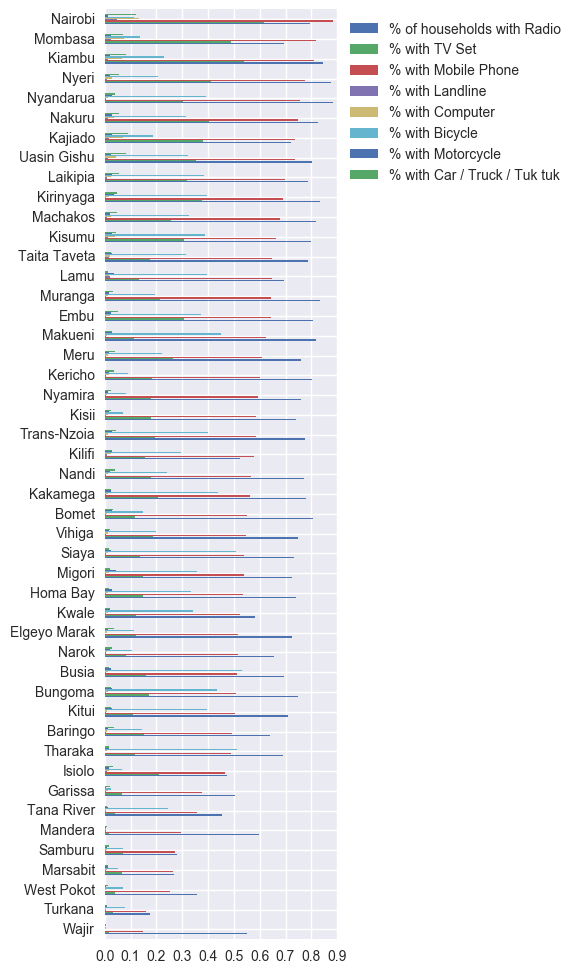

In [7]:
ax = (county_pct_household_asssets
         .sort_values(by='% with Mobile Phone')
         .plot
         .barh(figsize=(3, 12), lw=0))

ax.legend(loc="upper left",
          bbox_to_anchor=(1,1))


## Build materials
 - Roofing
 - Walls

In [8]:
se_data = '../data/raw/Socio Econonomic Data/'
fp = os.path.join(se_data,
                  'Census2009',
                  '2009_Census_Volume_II_Table_5_Households_by_main_type_of_Roofing_Material_for_the_main_dwelling_unit_by_district.csv')

roofing = pd.read_csv(fp,
                      index_col=0)

cols_to_use = [c for c in roofing.columns if 'No.' in c] + \
              ['County', 'Households']
    
roofing = roofing[cols_to_use]

# aggregate district -> county
roofing_by_county = roofing.groupby('County').sum()

# turn back into county pcts
roofing_by_county_pct = (roofing_by_county[[c for c in roofing_by_county.columns if 'No.' in c]]
                             .apply(lambda x: x / roofing_by_county['Households'], axis=0))

# rename columns appropriately
roofing_by_county_pct.columns = (pd.Series(roofing_by_county_pct.columns)
                                    .apply(lambda x: x.replace('No.', '%')))

roofing_by_county_pct.index = utils.resolve_county_names(roofing_by_county_pct.index, targets.index)

roofing_by_county_pct.head()

,% Corrugated Iron Sheets,% Tiles,% Concrete,% Asbestos Sheets,% Grass,% Makuti,% Tin,% Mud/Dung,% Other
Baringo,0.58,0.01,0.00,0.01,0.39,0.00,0.00,0.00,0.00
Bomet,0.73,0.01,0.01,0.01,0.24,0.00,0.00,0.00,0.00
Bungoma,0.78,0.01,0.00,0.03,0.18,0.00,0.00,0.00,0.00
Busia,0.50,0.01,0.00,0.02,0.47,0.00,0.00,0.00,0.00
Elgeyo Marak,0.58,0.01,0.00,0.01,0.39,0.00,0.00,0.00,0.01


In [9]:
se_data = '../data/raw/Socio Econonomic Data/'
fp = os.path.join(se_data,
                  'Census2009',
                  '2009_Census_Volume_II_Table_6__Households_by_main_type_of_Wall_Material_for_the_main_dwelling_unit__by_district.csv')

walls = pd.read_csv(fp,
                    index_col=0)

cols_to_use = [c for c in walls.columns if 'No' in c] + \
              ['County', 'Households']
    
walls = walls[cols_to_use]

# aggregate district -> county
walls_by_county = walls.groupby('County').sum()

# turn back into county pcts
walls_by_county_pct = (walls_by_county[[c for c in walls_by_county.columns if 'No' in c]]
                             .apply(lambda x: x / walls_by_county['Households'], axis=0))

# rename columns appropriately
walls_by_county_pct.columns = (pd.Series(walls_by_county_pct.columns)
                                    .apply(lambda x: x.replace('No', '%')))

walls_by_county_pct.index = utils.resolve_county_names(walls_by_county_pct.index, targets.index)

walls_by_county_pct.head()

,% of households with Stone,% of households with Brick/Block,% of households with Mud/Wood,% of households with Mud/Cement,% of households with Wood Only,% of households with Corrugated Iron Sheets,% of households with Grass/Reeds,% of households with Tin,% of households with Other
Baringo,0.05,0.04,0.51,0.06,0.26,0.06,0.02,0.00,0.01
Bomet,0.04,0.09,0.65,0.08,0.12,0.01,0.00,0.00,0.01
Bungoma,0.01,0.14,0.70,0.12,0.00,0.00,0.00,0.00,0.01
Busia,0.02,0.17,0.68,0.11,0.00,0.00,0.00,0.00,0.02
Elgeyo Marak,0.09,0.06,0.54,0.07,0.21,0.02,0.00,0.00,0.01


## Concatenate all Demographic Features

In [12]:
demographic_features = pd.concat([walls_by_county_pct,
                                  roofing_by_county_pct,
                                  county_pct_household_asssets,
                                  household_characteristics,
                                  pct_households_farming], axis=1)

In [13]:
demographic_features.to_csv("../data/processed/county-demo-features.csv")